In [1]:
cd ~/PycharmProjects/CleanSpace/momia2/

C:\Users\jzrol\PycharmProjects\CleanSpace\momia2


In [2]:
import momia2 as mo
import glob, numpy as np
from matplotlib import pyplot as plt
from skimage.measure import approximate_polygon
from skimage.filters import gaussian
from skimage.draw import polygon2mask

In [47]:
m = mo.ImageLoader('F:/20230531_Ghosh_imaging_pilot/A-_005.nd2')

for i in range(m.n_fields):
    data = m.get_slice_all_channels(position=i)
    p = mo.Patch(data)
    p.correct_xy_drift()
    p.crop_edge()
    p.preprocess_images(mo.utils.dual_bandpass,channels='ref',
                        pixel_microns=p.pixel_microns,
                        min_structure_scale=0.1,
                        max_structure_scale=50)
    p.preprocess_images(mo.utils.normalize_image,channels='ref',mask=1)
    p.preprocess_images(mo.utils.rolling_ball_bg_subtraction,channels='fl')
    p.generate_mask(method=1)
    p.label_mask()
    p.locate_particles()
    p.find_outline(approximate=True,tolerance=0.8,level=0.3,dilation=True)
    p.filter_particles({'area': (50, 1000),
                  'aspect_ratio': (0.05, 0.9),
                  'solidity': (0.7, 1),
                  'eccentricity': (0.1, 1),
                  'max_positive_curvature':(50,180),
                  'min_negative_curvature': (-10, 80),
                   "min_intensity":(0,0.3)})
    for i,x in zip(p.regionprops.index,p.regionprops['$include'].values):
        if x==1:
            p.get_particle_data(i)
    break

Rendering cell plot(s)...


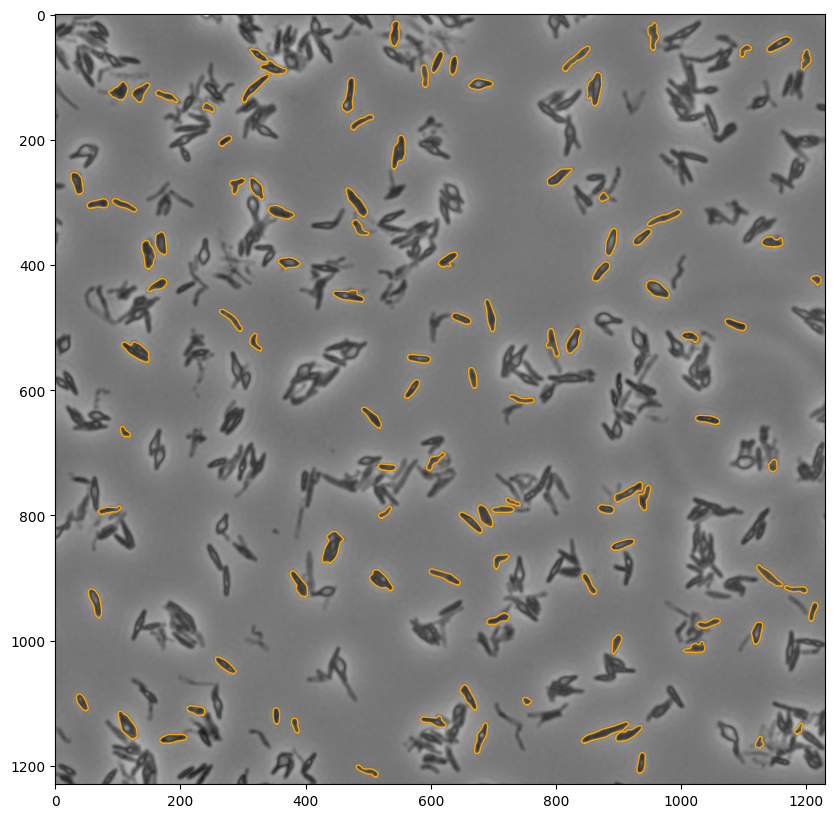

In [48]:
p.plot(figsize=(10,10))

In [67]:
for i,x in zip(p.regionprops.index,p.regionprops['$include'].values):
    if x==1 and i>120:
        mask = p.get_particle_mask(i)
        clip = p.get_particle_data(i)
        outline = p.regionprops.loc[i,'$outline']
        newmask = polygon2mask(mask.shape,outline)
        
        break

# help(polygon2mask)

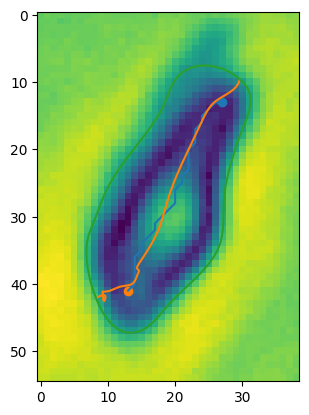

In [69]:
sk=mo.utils.skeleton_analysis(newmask,pruning=True,min_branch_length=5)
for x in sk[0]:
    xx=mo.utils.midline.midline_approximation(np.array(x[1:]).T,
                             outline,
                             move_pole1=x[0][0],
                             move_pole2=x[0][1],
                             anchor_length=5,
                             max_iteration=5,tolerance=0.01)[0]
    xx=mo.utils.midline.extend_skeleton(xx,
                       outline,
                       find_pole1=x[0][0],
                       find_pole2=x[0][1],
                       interpolation_factor=5)
    xx=mo.utils.midline.midline_approximation(xx,
                             outline,
                             move_pole1=x[0][0],
                             move_pole2=x[0][1],
                             anchor_length=10,
                             max_iteration=1,tolerance=0.01)[0]
   
    plt.scatter(x[2][0],x[1][0])
    plt.scatter(x[2][-1],x[1][-1])
    plt.plot(x[2],x[1])
    plt.plot(xx[:,1],xx[:,0])
plt.imshow(clip['Phase_Ian'])
plt.plot(outline[:,1],outline[:,0])

In [70]:
p.regionprops['orientation']

$label
1     -1.431528
2      0.280080
3      1.095753
4      0.817226
5      1.438458
         ...   
280   -1.377593
281    0.582678
282    1.222846
283   -0.480674
284   -0.688300
Name: orientation, Length: 284, dtype: float64

In [71]:
def midline_approximation(skeleton, 
                          smoothed_contour,
                          move_pole1 = False,
                          move_pole2 = False, 
                          anchor_length = 3,
                          tolerance=0.1, max_iteration=10):
    """
    Approximation of a smooth midline with skeleton and a smoothed contour.

    :param skeleton: A numpy array of shape (n, 2) representing the skeleton of a 2D object.
    :param smoothed_contour: A numpy array of shape (m, 2) representing the smoothed contour of a 2D object.
    :param tolerance: A float representing the maximum distance between the midline and the skeleton at which convergence is achieved.
    :param max_iteration: An integer representing the maximum number of iterations to perform.
    :return: A tuple containing a numpy array of shape (p, 2) representing the midline approximation and a boolean indicating whether convergence was achieved.
    """
    midline = skeleton.copy()
    pole1_anchor = []
    pole2_anchor = []
    
    if not move_pole1:
        pole1_anchor = midline[:anchor_length]
        midline = midline[anchor_length:]
    if not move_pole2:
        pole2_anchor = midline[-anchor_length:]
        midline = midline[:-anchor_length]
    
    n = 0
    converged = False
    while n < max_iteration:
        updated_midline = mo.utils.skeleton.skeleton_contour_intersect_points(midline, smoothed_contour)
        dxy = updated_midline - midline
        midline = mo.utils.linalg.spline_approximation(updated_midline, 
                                       n=len(updated_midline),
                                       smooth_factor=1, closed=False)
        if dxy.max() <= tolerance:
            converged = True
            break
        n += 1
        
    stiched_midline = []
    if not move_pole1:
        stiched_midline.append(pole1_anchor)
    stiched_midline.append(midline)
    if not move_pole2:
        stiched_midline.append(pole2_anchor)
    midline = np.vstack(stiched_midline)
    return midline.astype(np.float), converged

In [86]:
from skimage import measure,morphology,transform